# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os


2024-03-14 07:30:35.497614: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 07:30:35.523058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 07:30:35.523080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 07:30:35.523454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 07:30:35.527515: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

/home/big/Kevin/Workspace/Homework/ecec147/project/Deep-Learning-EEG-BCI-Signal-Processing/EEG-Data


(2115, 22, 1000)


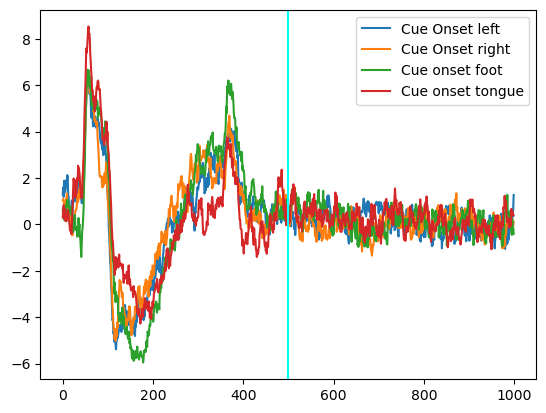

In [3]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






# Data Preprocessing

In [4]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

def eeg_fft(X):
    X_fft = np.fft.fft(X, axis=1)
    return np.concatenate([X_fft.real, X_fft.imag], axis=2)

x_train = eeg_fft(x_train)
x_valid = eeg_fft(x_valid)
x_test = eeg_fft(x_test)

Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (250, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (250, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460,

# CNN Model Architecture

In [5]:
from EEG_CNN import CNN
from EEG_ResNet import ResNetCustom, Good_Resnet

In [6]:
import itertools
# Building the CNN model using sequential class
mp = {'max pool' : True}
reg = {'reg 1e-3': 1e-3}
convdrop = {'conv drop': True}
filters = {'3x1 filter': 3, '5x1 filter': 5, '7x1 filter': 7, '10x1 filter': 10}
convdepth = {f'{i} convlayers' : i for i in range(2, 12, 2)}

models_names = []
models = []
for a in itertools.product(mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()):
    models_names.append([i[0] for i in a])
    print(models_names[-1])
    models.append(CNN(input_shape=(400,2,22), use_max_pool=a[0][1], reg=a[1][1], dropout_on_conv=a[2][1], 
                      filters=[a[3][1] for _ in range(a[4][1])],
                      num_filters=[min(200, 25 * (2 ** i)) for i in range(a[4][1])]))

# Printing the model summary
# basic_cnn_model.summary()


['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '2 convlayers']


2024-03-14 07:30:39.448787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 07:30:39.466528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 07:30:39.466696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '4 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '6 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '8 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '10 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '2 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '4 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '6 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '8 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '10 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '7x1 filter', '2 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '7x1 filter', '4 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '7x1 filter', '6 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '7x1 filter', '8 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '7x1 filter', '10 convlayers']
['max pool', 'reg 1e-3', 'conv drop', '10x1 f

# Train CNN Model

In [7]:
# Model parameter
# learning_rate = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps)
learning_rate = 3e-3
# learning_rate = 1e-4

epochs = 500
# epochs=1
# cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
# Compiling the model
from keras.callbacks import ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
for model in models:
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
histories = []
for model in models:
# Training and validating the model
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8,
                              patience=15, min_lr=3e-5)
    histories.append(model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[reduce_lr],
             verbose=True)
    )



Epoch 1/500


2024-03-14 07:30:42.998547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-14 07:30:43.116395: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-14 07:30:43.915343: I external/local_xla/xla/service/service.cc:168] XLA service 0x7eccd96e31f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 07:30:43.915365: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-14 07:30:43.918860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710426643.981192  175686 device_compiler.h:186] Compiled clust

117/117 [==============================] - 4s 14ms/step - loss: 2.2293 - accuracy: 0.2989 - val_loss: 1.6478 - val_accuracy: 0.3600 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 8ms/step - loss: 1.7222 - accuracy: 0.3702 - val_loss: 1.5842 - val_accuracy: 0.3480 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 7ms/step - loss: 1.5243 - accuracy: 0.4058 - val_loss: 1.3874 - val_accuracy: 0.4080 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 1s 8ms/step - loss: 1.4090 - accuracy: 0.4342 - val_loss: 1.4005 - val_accuracy: 0.3920 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 8ms/step - loss: 1.3092 - accuracy: 0.4802 - val_loss: 1.3036 - val_accuracy: 0.4800 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 10ms/step - loss: 1.2540 - accuracy: 0.5177 - val_loss: 1.3298 - val_accuracy: 0.4320 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 1s 10ms/step - loss

2024-03-14 07:39:45.509955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 4s 17ms/step - loss: 2.3494 - accuracy: 0.2650 - val_loss: 1.8944 - val_accuracy: 0.2240 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 11ms/step - loss: 2.0081 - accuracy: 0.2733 - val_loss: 1.7257 - val_accuracy: 0.2520 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 12ms/step - loss: 1.8934 - accuracy: 0.2807 - val_loss: 1.7464 - val_accuracy: 0.2520 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 1s 11ms/step - loss: 1.8203 - accuracy: 0.2779 - val_loss: 1.8262 - val_accuracy: 0.2560 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 12ms/step - loss: 1.7589 - accuracy: 0.2918 - val_loss: 1.6397 - val_accuracy: 0.3440 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 12ms/step - loss: 1.7103 - accuracy: 0.2979 - val_loss: 1.6148 - val_accuracy: 0.3360 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 1s 12ms/step - 

2024-03-14 07:51:26.537472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 20ms/step - loss: 2.5694 - accuracy: 0.2638 - val_loss: 2.1563 - val_accuracy: 0.2640 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 12ms/step - loss: 2.2341 - accuracy: 0.2559 - val_loss: 2.0827 - val_accuracy: 0.2440 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 14ms/step - loss: 2.0864 - accuracy: 0.2666 - val_loss: 1.9717 - val_accuracy: 0.2560 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 13ms/step - loss: 1.9572 - accuracy: 0.2706 - val_loss: 1.8829 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 14ms/step - loss: 1.8852 - accuracy: 0.2756 - val_loss: 1.8206 - val_accuracy: 0.2640 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 13ms/step - loss: 1.7939 - accuracy: 0.2767 - val_loss: 1.7356 - val_accuracy: 0.2960 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 14ms/step - 

2024-03-14 08:04:20.199493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 4s 16ms/step - loss: 2.7821 - accuracy: 0.2586 - val_loss: 2.3605 - val_accuracy: 0.2400 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 12ms/step - loss: 2.4409 - accuracy: 0.2572 - val_loss: 2.3031 - val_accuracy: 0.2760 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 12ms/step - loss: 2.2983 - accuracy: 0.2669 - val_loss: 2.1963 - val_accuracy: 0.2720 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 1s 12ms/step - loss: 2.1997 - accuracy: 0.2527 - val_loss: 2.1343 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 13ms/step - loss: 2.0888 - accuracy: 0.2615 - val_loss: 2.0455 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 11ms/step - loss: 1.9980 - accuracy: 0.2752 - val_loss: 1.9546 - val_accuracy: 0.2480 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 1s 12ms/step - 

2024-03-14 08:18:05.831223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 16ms/step - loss: 2.9767 - accuracy: 0.2633 - val_loss: 2.5499 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 12ms/step - loss: 2.6173 - accuracy: 0.2511 - val_loss: 2.5072 - val_accuracy: 0.2320 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 11ms/step - loss: 2.5279 - accuracy: 0.2635 - val_loss: 2.4256 - val_accuracy: 0.2480 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 17ms/step - loss: 2.4341 - accuracy: 0.2643 - val_loss: 2.3735 - val_accuracy: 0.2360 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 17ms/step - loss: 2.3385 - accuracy: 0.2642 - val_loss: 2.2464 - val_accuracy: 0.2960 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 17ms/step - loss: 2.2499 - accuracy: 0.2693 - val_loss: 2.1549 - val_accuracy: 0.3000 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 17ms/step - 

2024-03-14 08:32:51.440854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 3s 12ms/step - loss: 2.1797 - accuracy: 0.3164 - val_loss: 1.8590 - val_accuracy: 0.3560 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 10ms/step - loss: 1.7332 - accuracy: 0.3723 - val_loss: 1.6675 - val_accuracy: 0.2960 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 8ms/step - loss: 1.5216 - accuracy: 0.4032 - val_loss: 1.4020 - val_accuracy: 0.3680 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 1s 10ms/step - loss: 1.3702 - accuracy: 0.4587 - val_loss: 1.3649 - val_accuracy: 0.3840 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 9ms/step - loss: 1.2984 - accuracy: 0.4957 - val_loss: 1.3496 - val_accuracy: 0.4040 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 10ms/step - loss: 1.2586 - accuracy: 0.5182 - val_loss: 1.3295 - val_accuracy: 0.4160 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 1s 11ms/step - lo

2024-03-14 08:42:01.695270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 3s 12ms/step - loss: 2.4793 - accuracy: 0.2536 - val_loss: 2.5692 - val_accuracy: 0.2240 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 11ms/step - loss: 2.0577 - accuracy: 0.2552 - val_loss: 1.8098 - val_accuracy: 0.2920 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 11ms/step - loss: 1.9353 - accuracy: 0.2704 - val_loss: 1.7551 - val_accuracy: 0.3000 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 1s 12ms/step - loss: 1.8676 - accuracy: 0.2739 - val_loss: 1.7213 - val_accuracy: 0.2840 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 12ms/step - loss: 1.8006 - accuracy: 0.2814 - val_loss: 1.7222 - val_accuracy: 0.2920 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 13ms/step - loss: 1.7414 - accuracy: 0.3051 - val_loss: 1.6463 - val_accuracy: 0.3160 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 1s 11ms/step - 

2024-03-14 08:53:18.247811: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 19ms/step - loss: 2.5717 - accuracy: 0.2499 - val_loss: 2.1777 - val_accuracy: 0.2520 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 12ms/step - loss: 2.2159 - accuracy: 0.2744 - val_loss: 2.0802 - val_accuracy: 0.2680 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 13ms/step - loss: 2.0802 - accuracy: 0.2685 - val_loss: 1.9588 - val_accuracy: 0.2960 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 14ms/step - loss: 1.9398 - accuracy: 0.2857 - val_loss: 1.9231 - val_accuracy: 0.2560 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 14ms/step - loss: 1.8725 - accuracy: 0.2791 - val_loss: 1.8387 - val_accuracy: 0.2720 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 14ms/step - loss: 1.7727 - accuracy: 0.2924 - val_loss: 1.7878 - val_accuracy: 0.3120 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 14ms/step - 

2024-03-14 09:06:18.537381: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 18ms/step - loss: 2.6846 - accuracy: 0.2555 - val_loss: 2.4129 - val_accuracy: 0.2720 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 14ms/step - loss: 2.3152 - accuracy: 0.2647 - val_loss: 2.2029 - val_accuracy: 0.2480 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 12ms/step - loss: 2.1909 - accuracy: 0.2678 - val_loss: 2.0790 - val_accuracy: 0.2960 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 13ms/step - loss: 2.0856 - accuracy: 0.2772 - val_loss: 2.1160 - val_accuracy: 0.2360 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 14ms/step - loss: 1.9836 - accuracy: 0.2839 - val_loss: 1.9425 - val_accuracy: 0.2280 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 14ms/step - loss: 1.9006 - accuracy: 0.2869 - val_loss: 2.0225 - val_accuracy: 0.2680 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 14ms/step - 

2024-03-14 09:19:23.500224: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_50/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 18ms/step - loss: 2.8363 - accuracy: 0.2564 - val_loss: 2.6010 - val_accuracy: 0.2480 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 17ms/step - loss: 2.4814 - accuracy: 0.2597 - val_loss: 2.3558 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 16ms/step - loss: 2.3950 - accuracy: 0.2558 - val_loss: 2.2745 - val_accuracy: 0.2880 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 17ms/step - loss: 2.2862 - accuracy: 0.2681 - val_loss: 2.2644 - val_accuracy: 0.2760 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 17ms/step - loss: 2.1932 - accuracy: 0.2772 - val_loss: 2.1186 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 17ms/step - loss: 2.1115 - accuracy: 0.2819 - val_loss: 2.0453 - val_accuracy: 0.3040 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 17ms/step - 

2024-03-14 09:35:56.553074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_60/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 3s 15ms/step - loss: 2.2144 - accuracy: 0.3083 - val_loss: 1.7494 - val_accuracy: 0.3800 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 10ms/step - loss: 1.7689 - accuracy: 0.3763 - val_loss: 1.5467 - val_accuracy: 0.3440 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 9ms/step - loss: 1.5363 - accuracy: 0.4004 - val_loss: 1.4657 - val_accuracy: 0.3600 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 1s 10ms/step - loss: 1.3944 - accuracy: 0.4520 - val_loss: 1.3662 - val_accuracy: 0.4600 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 10ms/step - loss: 1.3105 - accuracy: 0.4930 - val_loss: 1.3884 - val_accuracy: 0.4080 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 10ms/step - loss: 1.2581 - accuracy: 0.5208 - val_loss: 1.3598 - val_accuracy: 0.4040 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 1s 11ms/step - l

2024-03-14 09:45:43.213178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_62/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 4s 17ms/step - loss: 2.4789 - accuracy: 0.2689 - val_loss: 2.0794 - val_accuracy: 0.2640 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 12ms/step - loss: 2.0702 - accuracy: 0.2760 - val_loss: 1.7792 - val_accuracy: 0.3040 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 11ms/step - loss: 1.9538 - accuracy: 0.2724 - val_loss: 1.8291 - val_accuracy: 0.2720 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 13ms/step - loss: 1.8977 - accuracy: 0.2887 - val_loss: 1.8663 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 11ms/step - loss: 1.7821 - accuracy: 0.3111 - val_loss: 1.6610 - val_accuracy: 0.2640 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 13ms/step - loss: 1.7550 - accuracy: 0.3214 - val_loss: 1.6433 - val_accuracy: 0.3560 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 13ms/step - 

2024-03-14 09:57:57.430168: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_66/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 20ms/step - loss: 2.5304 - accuracy: 0.2607 - val_loss: 2.1935 - val_accuracy: 0.2560 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 14ms/step - loss: 2.1743 - accuracy: 0.2788 - val_loss: 2.0157 - val_accuracy: 0.2640 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 15ms/step - loss: 2.0187 - accuracy: 0.2753 - val_loss: 1.9436 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 15ms/step - loss: 1.9071 - accuracy: 0.2725 - val_loss: 1.8746 - val_accuracy: 0.2480 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 15ms/step - loss: 1.8144 - accuracy: 0.2847 - val_loss: 1.7529 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 15ms/step - loss: 1.7321 - accuracy: 0.2912 - val_loss: 1.6837 - val_accuracy: 0.2960 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 15ms/step - 

2024-03-14 10:11:49.887436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_72/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 18ms/step - loss: 2.6547 - accuracy: 0.2572 - val_loss: 2.5581 - val_accuracy: 0.2280 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 14ms/step - loss: 2.3094 - accuracy: 0.2704 - val_loss: 2.1603 - val_accuracy: 0.2320 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 15ms/step - loss: 2.2120 - accuracy: 0.2689 - val_loss: 2.0749 - val_accuracy: 0.3040 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 15ms/step - loss: 2.0735 - accuracy: 0.2658 - val_loss: 1.9883 - val_accuracy: 0.2560 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 16ms/step - loss: 1.9738 - accuracy: 0.2598 - val_loss: 1.8942 - val_accuracy: 0.2880 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 17ms/step - loss: 1.8837 - accuracy: 0.2803 - val_loss: 1.8717 - val_accuracy: 0.2240 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 17ms/step - 

2024-03-14 10:27:17.935302: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_80/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 19ms/step - loss: 2.7903 - accuracy: 0.2574 - val_loss: 2.4612 - val_accuracy: 0.2560 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 17ms/step - loss: 2.4403 - accuracy: 0.2571 - val_loss: 2.3004 - val_accuracy: 0.2600 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 17ms/step - loss: 2.3400 - accuracy: 0.2661 - val_loss: 2.2287 - val_accuracy: 0.2400 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 17ms/step - loss: 2.2412 - accuracy: 0.2686 - val_loss: 2.1615 - val_accuracy: 0.2440 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 17ms/step - loss: 2.1694 - accuracy: 0.2717 - val_loss: 2.0712 - val_accuracy: 0.2880 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 17ms/step - loss: 2.0743 - accuracy: 0.2725 - val_loss: 1.9990 - val_accuracy: 0.2840 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 17ms/step - 

2024-03-14 10:43:32.867851: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/dropout_90/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 3s 14ms/step - loss: 2.3293 - accuracy: 0.2929 - val_loss: 2.3101 - val_accuracy: 0.3080 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 10ms/step - loss: 1.7898 - accuracy: 0.3501 - val_loss: 1.8374 - val_accuracy: 0.2800 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 1s 11ms/step - loss: 1.5575 - accuracy: 0.3999 - val_loss: 1.4740 - val_accuracy: 0.4000 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 1s 10ms/step - loss: 1.4106 - accuracy: 0.4428 - val_loss: 1.3352 - val_accuracy: 0.4120 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 10ms/step - loss: 1.3145 - accuracy: 0.4946 - val_loss: 1.3494 - val_accuracy: 0.4240 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 11ms/step - loss: 1.2634 - accuracy: 0.5236 - val_loss: 1.3417 - val_accuracy: 0.4680 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 1s 10ms/step - 

2024-03-14 10:52:56.685164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_92/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 4s 17ms/step - loss: 2.5463 - accuracy: 0.2503 - val_loss: 2.5187 - val_accuracy: 0.2520 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 1s 13ms/step - loss: 2.0891 - accuracy: 0.2658 - val_loss: 1.8408 - val_accuracy: 0.2440 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 13ms/step - loss: 1.9472 - accuracy: 0.2796 - val_loss: 1.7647 - val_accuracy: 0.2840 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 13ms/step - loss: 1.8694 - accuracy: 0.2755 - val_loss: 1.7513 - val_accuracy: 0.2720 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 1s 11ms/step - loss: 1.8364 - accuracy: 0.2879 - val_loss: 1.6744 - val_accuracy: 0.3200 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 1s 12ms/step - loss: 1.7388 - accuracy: 0.3091 - val_loss: 1.6671 - val_accuracy: 0.2520 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 1s 9ms/step - l

2024-03-14 11:04:44.326454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/dropout_96/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 21ms/step - loss: 2.5412 - accuracy: 0.2524 - val_loss: 2.5270 - val_accuracy: 0.2520 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 15ms/step - loss: 2.1782 - accuracy: 0.2727 - val_loss: 2.0600 - val_accuracy: 0.2880 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 15ms/step - loss: 2.0208 - accuracy: 0.2832 - val_loss: 1.9038 - val_accuracy: 0.3200 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 15ms/step - loss: 1.8938 - accuracy: 0.2869 - val_loss: 1.8713 - val_accuracy: 0.3000 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 16ms/step - loss: 1.8117 - accuracy: 0.2891 - val_loss: 1.7301 - val_accuracy: 0.3040 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 15ms/step - loss: 1.7259 - accuracy: 0.3071 - val_loss: 1.6709 - val_accuracy: 0.3360 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 15ms/step - 

2024-03-14 11:19:32.718098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_102/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 5s 20ms/step - loss: 2.6194 - accuracy: 0.2613 - val_loss: 2.3996 - val_accuracy: 0.2200 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 16ms/step - loss: 2.2875 - accuracy: 0.2552 - val_loss: 2.1420 - val_accuracy: 0.2440 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 17ms/step - loss: 2.1467 - accuracy: 0.2714 - val_loss: 2.0211 - val_accuracy: 0.3040 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 16ms/step - loss: 2.0250 - accuracy: 0.2788 - val_loss: 1.9666 - val_accuracy: 0.3000 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 16ms/step - loss: 1.9314 - accuracy: 0.2763 - val_loss: 1.9140 - val_accuracy: 0.2720 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 15ms/step - loss: 1.8463 - accuracy: 0.2897 - val_loss: 1.7795 - val_accuracy: 0.2760 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 14ms/step - 

2024-03-14 11:35:35.847275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_110/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 6s 20ms/step - loss: 2.7131 - accuracy: 0.2564 - val_loss: 3.2434 - val_accuracy: 0.2280 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 19ms/step - loss: 2.3879 - accuracy: 0.2685 - val_loss: 2.2558 - val_accuracy: 0.2320 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 18ms/step - loss: 2.2898 - accuracy: 0.2639 - val_loss: 2.1848 - val_accuracy: 0.2400 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 17ms/step - loss: 2.1817 - accuracy: 0.2701 - val_loss: 2.0900 - val_accuracy: 0.2880 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 18ms/step - loss: 2.0904 - accuracy: 0.2654 - val_loss: 2.0242 - val_accuracy: 0.2400 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 18ms/step - loss: 2.0181 - accuracy: 0.2783 - val_loss: 1.9475 - val_accuracy: 0.2680 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 17ms/step - 

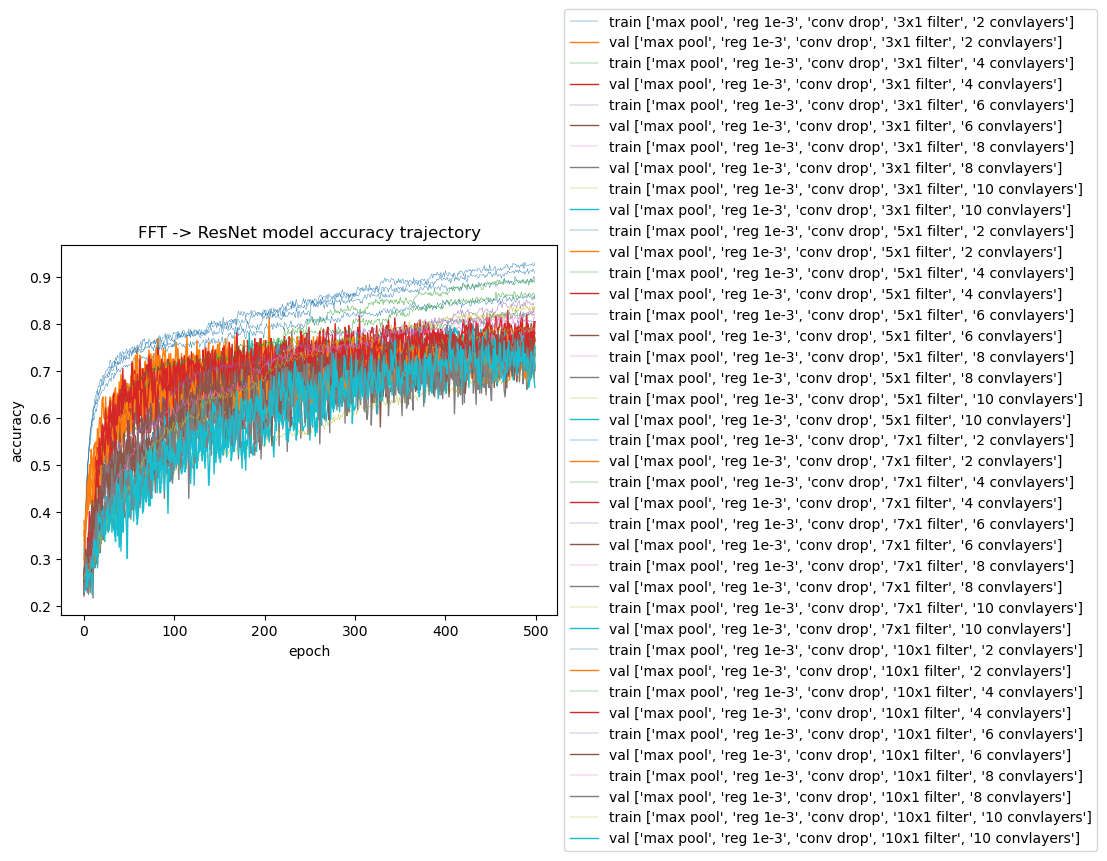

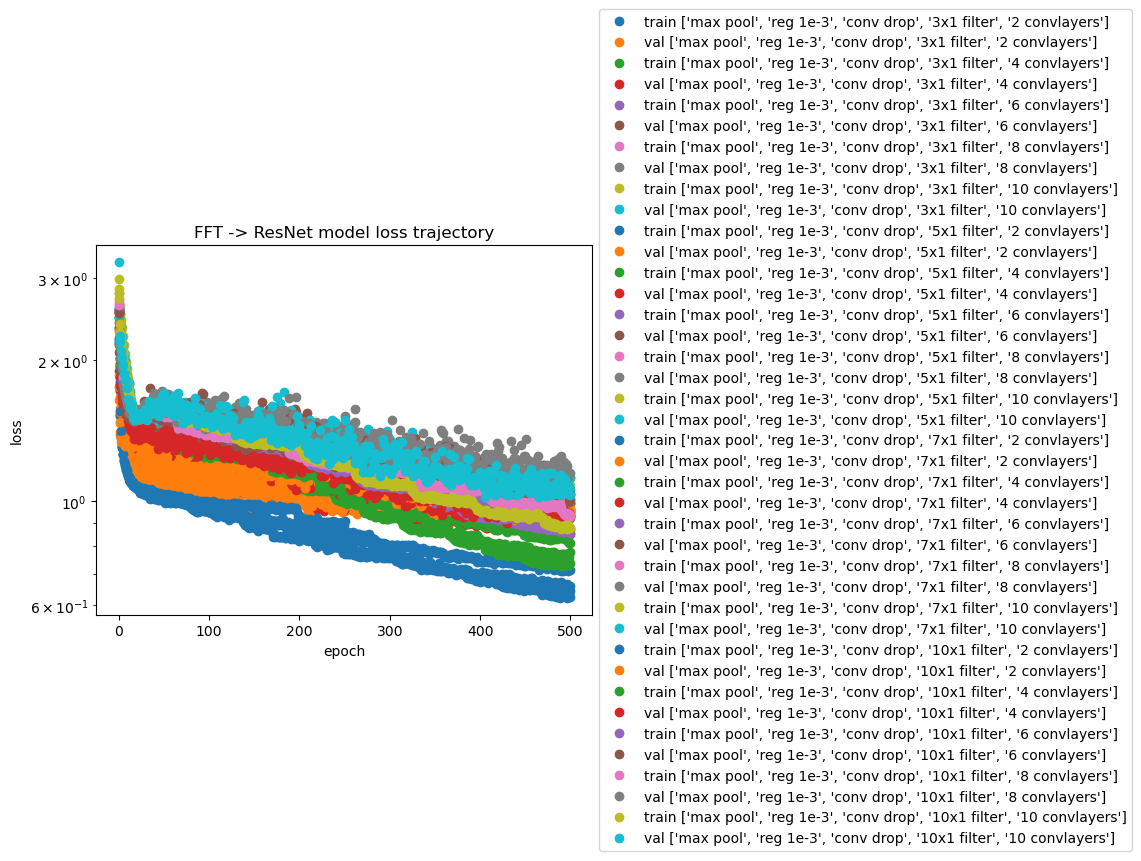

In [9]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
for hist in histories:
    plt.plot(hist.history['accuracy'], linewidth=0.3)
    plt.plot(hist.history['val_accuracy'], linewidth=1)
plt.title('FFT -> ResNet model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
labels = []
for name in models_names:
    labels.append(f'train {name}')
    labels.append(f'val {name}')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
for hist in histories:
    plt.plot(hist.history['loss'],'o')
    plt.plot(hist.history['val_loss'],'o')
plt.title('FFT -> ResNet model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
## Testing 
from keras.models import save_model
from keras.utils import plot_model
for model, name in zip(models, models_names):
    cnn_score = model.evaluate(x_test, y_test, verbose=0)
    if cnn_score[1] > 0.7:
        # Save entire model
        model_filename = f'../Models/FFT_deep_model{cnn_score[1]}.h5'
        model.save(model_filename)

        # Save weights only
        weights_filename = f'../Models/FFT_deep_weights{cnn_score[1]}.h5'
        model.save_weights(weights_filename)
    print(f'Test accuracy of {name}:',cnn_score[1])

Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '2 convlayers']: 0.6636568903923035


/home/big/miniforge3/envs/c147/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '4 convlayers']: 0.7178329825401306
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '6 convlayers']: 0.715575635433197
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '8 convlayers']: 0.6049661636352539
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '10 convlayers']: 0.6162528395652771
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '2 convlayers']: 0.6681715846061707
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '4 convlayers']: 0.6930022835731506
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '6 convlayers']: 0.6930022835731506
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '8 convlayers']: 0.7020316123962402
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '10 convlayers']: 0.6749435663223267
Test accuracy of ['max pool', 'reg 1e-3', 'conv drop',

In [11]:
from keras.models import save_model
from keras.utils import plot_model

# # Save entire model
# model_filename = f'../Models/FFT_deep_model{cnn_score[1]}.h5'
# model.save(model_filename)

# # Save weights only
# weights_filename = f'../Models/FFT_deep_weights{cnn_score[1]}.h5'
# model.save_weights(weights_filename)
# Load weights into a new model with the same architecture
# loaded_model = create_resnet_lstm_model() # create using resnet-15 architecture
# loaded_model.load_weights(weights_filename)

In [12]:
maxes_ = []
finals_ = []
for model, name in zip(histories, models_names):
    maxes_.append(max(model.history['val_accuracy']))
    finals_.append(model.history['val_accuracy'][-1])
    print(f"Validation accuracy {name}: max: {max(model.history['val_accuracy'])}, final: {model.history['val_accuracy'][-1]}")
for pair in sorted(zip(finals_, models_names), key=lambda i: i[0], reverse=True):
    print(pair)

Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '2 convlayers']: max: 0.7680000066757202, final: 0.7319999933242798
Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '4 convlayers']: max: 0.8199999928474426, final: 0.8040000200271606
Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '6 convlayers']: max: 0.800000011920929, final: 0.7639999985694885
Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '8 convlayers']: max: 0.7720000147819519, final: 0.7080000042915344
Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '3x1 filter', '10 convlayers']: max: 0.7680000066757202, final: 0.6639999747276306
Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '2 convlayers']: max: 0.7559999823570251, final: 0.7039999961853027
Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '4 convlayers']: max: 0.7839999794960022, final: 0.7799999713897705
Validation accuracy 

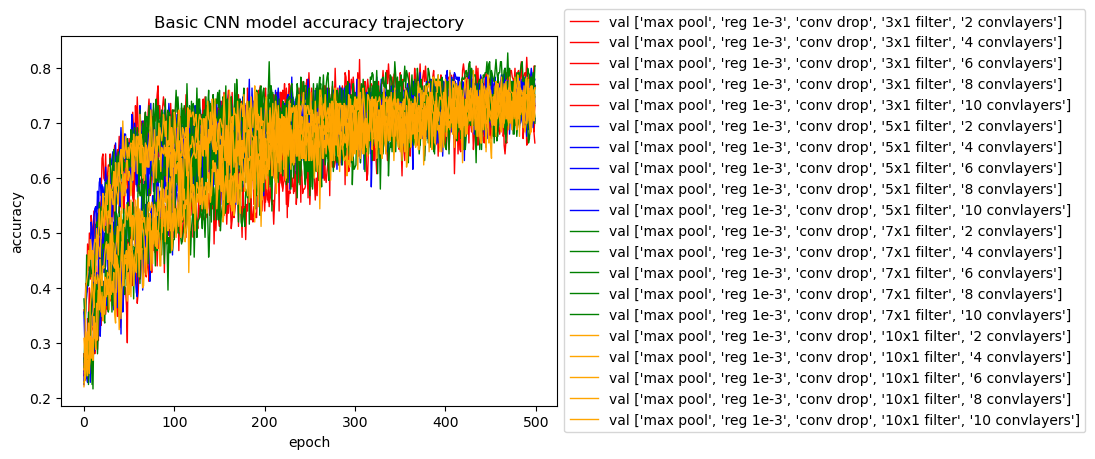

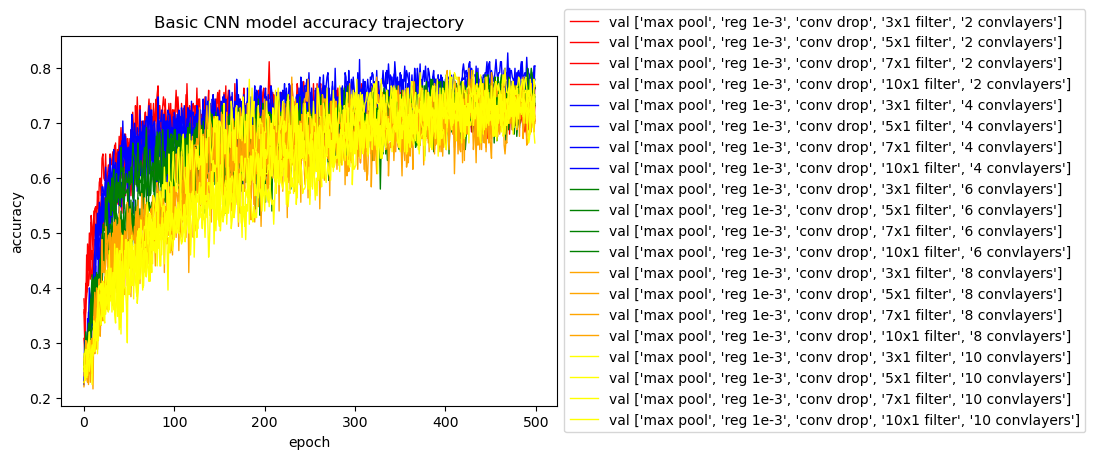

In [13]:
color = ['r', 'b', 'g', 'orange', 'yellow']
for param in [mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()]:
    if len(param) == 1:
        continue
    for i, param_name in enumerate(param):
        for name, label, history in zip(models_names, labels[1::2], histories):
            if param_name[0] in name:
                plt.plot(history.history['val_accuracy'], linewidth=1, color=color[i], label=label)
    plt.title('Basic CNN model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()